# Loan Eligibility Predictor 

In [1]:
# Dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path
from pprint import pprint
from utils import *
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report

### Data 

In [2]:
# Datasets 
train_data_path = Path("./dataset/train.csv") 
test_data_path = Path("./dataset/test.csv") 
train_data = pd.read_csv(train_data_path, encoding='utf-8', index_col='Loan_ID')
test_data = pd.read_csv(test_data_path, encoding='utf-8', index_col='Loan_ID')

train_data = train_data.drop('Credit_History', axis=1)
test_data = test_data.drop('Credit_History', axis=1)

In [3]:
# Missing column in test_data
print(list(set(train_data.columns) - set(test_data.columns))[0])

Loan_Status


In [4]:
# DataFrame Shape Comparision
train_data.shape, train_data.dropna().shape

((6614, 11), (6172, 11))

In [5]:
df_NaN_Status(train_data)

Gender              	133/6614
Married             	 3/6614
Dependents          	15/6614
Education           	 0/6614
Self_Employed       	152/6614
ApplicantIncome     	 0/6614
CoapplicantIncome   	 0/6614
LoanAmount          	142/6614
Loan_Amount_Term    	14/6614
Property_Area       	 0/6614
Loan_Status         	 0/6614


### Data Fetch and Engineering

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_data(train_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got          Gender Married Dependents     Education Self_Employed  \
Loan_ID                                                          
LP001015   Male     Yes          0      Graduate            No   
LP001022   Male     Yes          1      Graduate            No   
LP001031   Male     Yes          2      Graduate            No   
LP001035   Male     Yes          2      Graduate            No   
LP001051   Male      No          0  Not Graduate            No   
...         ...     ...        ...           ...           ...   
LP002971   Male     Yes         3+  Not Graduate           Yes   
LP002975   Male     Yes          0      Graduate            No   
LP002980   Male      No          0      Graduate            No   
LP002986   Male     Yes          0      Graduate            No   
LP002989   Male      No          0      Graduate           Yes   

          ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001015             5720                  0       110.0             360.0   
LP001022             3076               1500       126.0             360.0   
LP001031             5000               1800       208.0             360.0   
LP001035             2340               2546       100.0             360.0   
LP001051             3276                  0        78.0             360.0   
...                   ...                ...         ...               ...   
LP002971             4009               1777       113.0             360.0   
LP002975             4158                709       115.0             360.0   
LP002980             3250               1993       126.0             360.0   
LP002986             5000               2393       158.0             360.0   
LP002989             9200                  0        98.0             180.0   

         Property_Area  
Loan_ID                 
LP001015         Urban  
LP001022         Urban  
LP001031         Urban  
LP001035         Urban  
LP001051         Urban  
...                ...  
LP002971         Urban  
LP002975         Urban  
LP002980     Semiurban  
LP002986         Rural  
LP002989         Rural  

[367 rows x 10 columns] instead.

In [ ]:
X_train.dtypes

Gender                            int64
Married                           int64
Dependents                        int64
Education                         int64
Self_Employed                     int64
ApplicantIncome                 float64
CoapplicantIncome               float64
LoanAmount                      float64
Loan_Amount_Term                float64
Property_Area                     int64
Total_Income                    float64
EMI                             float64
DTI                             float64
Debt_to_Income                  float64
Income_Per_Capita               float64
Income_to_EMI_Ratio             float64
Income_Stability                float64
Loan_Income_Ratio               float64
Loan_Term_Monthly               float64
Monthly_Income                  float64
LoanAmount_Log                  float64
ApplicantIncome_Log             float64
Income_Education_Interaction    float64
Loan_Property_Interaction       float64
Log_Total_Income                float64


### Model (Random Forrest and Logistic Regression Models)

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(tol=0.0001, fit_intercept=True, verbose=False), 
    'RandomForrestClassifierParameterized': RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=4, min_samples_split=10, random_state=42), 
    'RandomForrestClassifierDefault': RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True, class_weight='balanced'), # Best performing
    'RandomForrestClassifierParloured': RandomForestClassifier(n_estimators=300, max_features=int(0.4 * len(X_train.columns)),
                                                            random_state=42, warm_start=True, class_weight='balanced', max_leaf_nodes=5) 
}
model = models['RandomForrestClassifierDefault']
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42,
                       warm_start=True)

### Hyperparameter tuning (for best model param selection)

In [ ]:
# Testing different hyperparameters for best model selection
hyperparam_grid = {
    'n_estimators'      : [100, 200, 300],
    'max_depth'         : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4]
}

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), hyperparam_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

# RECENT TESTED: 
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

### Model Evalutation (Regression Models)

In [ ]:
# Cross Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

# Feature Importances df
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_ * 100
}).sort_values('importance', ascending=False, ignore_index=True)

print("\nFeature Importance: ")
print(feature_importance)


Cross-validation scores: [0.66582704 0.65743073 0.66722689 0.67226891 0.67142857]
Average CV score: 0.6668364272661205

Feature Importance: 
                         feature  importance
0              Income_Per_Capita    6.552413
1              Loan_Income_Ratio    6.020748
2              CoapplicantIncome    5.920927
3               Income_Stability    5.701648
4            ApplicantIncome_Log    5.631595
5            Income_to_EMI_Ratio    5.585896
6                ApplicantIncome    5.485459
7                 Debt_to_Income    5.179801
8      Income_Loan_Ratio_Squared    5.145137
9                            EMI    5.046478
10     Loan_Property_Interaction    5.035921
11                           DTI    5.001409
12                  Total_Income    4.927446
13              Log_Total_Income    4.909563
14                Monthly_Income    4.842851
15                    LoanAmount    4.630797
16                LoanAmount_Log    4.510229
17  Income_Education_Interaction    2.615344
18 

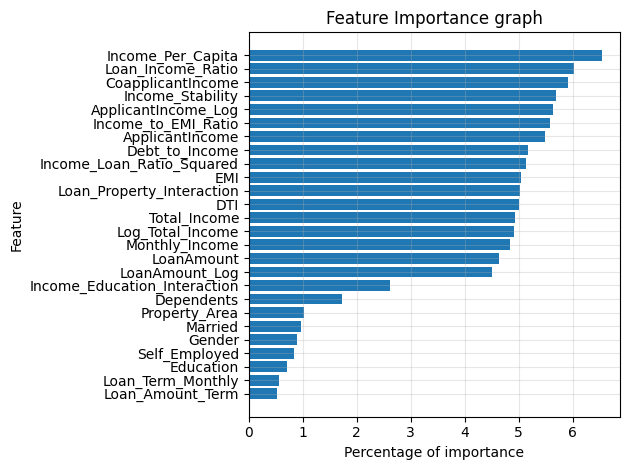

In [ ]:
# Plot feature importances 
_feature_importance = feature_importance.sort_values(by='importance', ascending=True)
plt.barh(_feature_importance['feature'], _feature_importance['importance'])
plt.title("Feature Importance graph")
plt.xlabel("Percentage of importance")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [ ]:
# F1 Score
y_pred = model.predict(X_test)
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(X_test.shape, y_test.shape, y_pred.shape)

print("F1 Score: ", f1)

# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("\nConfustion Matrix: \t")
print(cm)

print()
# Classfication report 
print(classification_report(y_true=y_test, y_pred=y_pred))

cm_ravel_cpms = ['True negative', 'False Positive', 'False negative', 'True Positive'] 

print()
pd.DataFrame({
    'Component': cm_ravel_cpms, 
    'Value' : cm.ravel()
})

(662, 26) (662,) (662,)
F1 Score:  0.7846441947565543

Confustion Matrix: 	
[[ 13 205]
 [ 25 419]]

              precision    recall  f1-score   support

           0       0.34      0.06      0.10       218
           1       0.67      0.94      0.78       444

    accuracy                           0.65       662
   macro avg       0.51      0.50      0.44       662
weighted avg       0.56      0.65      0.56       662




,Component,Value
0,True negative,13
1,False Positive,205
2,False negative,25
3,True Positive,419


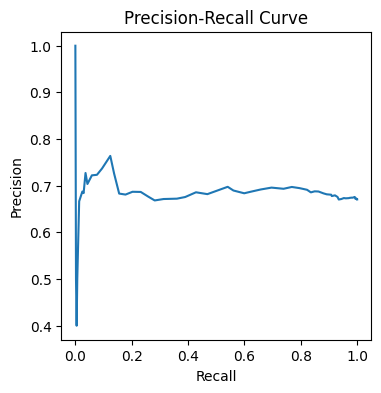

ROC-AUC Score: 0.5336753037441111


In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f'ROC-AUC Score: {roc_auc}')

Loan_Approval_Status
Y    94.259819
N     5.740181
Name: proportion, dtype: float64


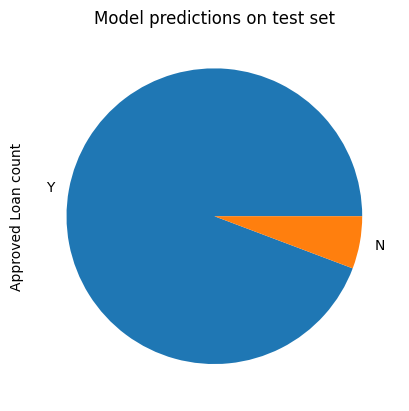

In [ ]:
# Test predicitons with test dataset 
test_predictions = model.predict(X_test)
test_predictions_proba = model.predict_proba(X_test)

# Save predictions
predictions_df = pd.DataFrame({
    'Loan_ID': X_test.index,
    'Loan_Approval_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
    'Confidence (%)': test_predictions_proba[:, 1]
})

print(predictions_df['Loan_Approval_Status'].value_counts(normalize=True) * 100)

predictions_pie = predictions_df['Loan_Approval_Status'].value_counts()\
    .plot(kind='pie', title='Model predictions on test set', ylabel="Approved Loan count")

### Test on sample data

In [ ]:
# Example usage
sample_input = {
    'Gender'            : 'Male', 
    'Married'           : 'Yes', 
    'Dependents'        : '1',
    'Education'         : 'Graduate', 
    'Self_Employed'     : 'Yes',
    'ApplicantIncome'   : 50000, 
    'CoapplicantIncome' : 1000,
    'LoanAmount'        : 1000, 
    'Loan_Amount_Term'  : 60,
    'Property_Area'     : 'Rural'
}
status, confidence = predict_loan_eligibility(model, sample_input)
print(f"Loan Status: {status}, Confidence of approval: {confidence:.2%}")

Loan Status: Y, Confidence of approval: 70.00%


### Save the model 

In [ ]:
save_model(model=model, fp="/Users/samarth/Programming/Loaner/model/rfc.pkl")